In [ ]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 5.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


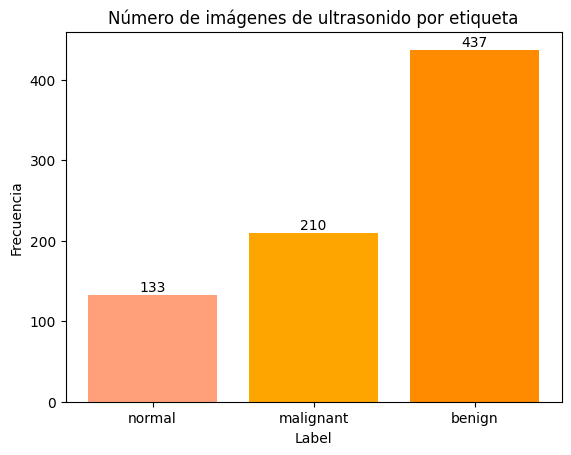

<built-in method items of dict object at 0x7e94d367bf80>


In [ ]:
## Avance 1 de proyecto
## Título: Comparación de algoritmos de segmentación para la detección de cáncer de mama a partir de imágenes de ultrasonido
## Autores: Alessandra Mercedes Aldave Javier, Valeria Oriana Zavaleta Jave


# Importación de librerías
import os
import glob
import matplotlib.pyplot as plt
from collections import Counter
import cv2
import random
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


#Paths en google drive
normal_path = "/content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal"
malignant_path = "/content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant"
benign_path = "/content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign"


# Paths de la ubicación de cada carpeta de datos
#normal_path = r"C:\Users\Alessandra\Downloads\ProyectoReconocimientoPatrones\Avance1\Dataset_BUSI_with_GT\normal"
#malignant_path = r"C:\Users\Alessandra\Downloads\ProyectoReconocimientoPatrones\Avance1\Dataset_BUSI_with_GT\malignant"
#benign_path = r"C:\Users\Alessandra\Downloads\ProyectoReconocimientoPatrones\Avance1\Dataset_BUSI_with_GT\benign"


# Función para cargar dataset de imágenes
    # Se usara un diccionario para guardar el path correspondiente a una imagen x (como key), y como value se tendra una lista cuyos elementos son: la etiqueta de esa imagen x, y el path de la mascara de la imagen x (lo mismo para todas las imagenes)
def CargarImagenesYMascaras(path_de_file):
    dataset = {} # Creación del diccionario
    for path_de_imagen in glob.glob(os.path.join(path_de_file, '*.png')):
        filename = os.path.basename(path_de_imagen)
        label = filename.split('(')[0].strip()
        if "_mask" not in filename:
            mask_path = os.path.join(path_de_file, filename.replace('.png', '_mask.png'))
            if os.path.exists(mask_path):
                dataset[path_de_imagen] = [label, mask_path]
    return dataset

# Cargar paths de imágenes de ultrasonido con su respectivo label y path de imagenes de mascaras
dataset = {}
dataset.update(CargarImagenesYMascaras(normal_path))
dataset.update(CargarImagenesYMascaras(malignant_path))
dataset.update(CargarImagenesYMascaras(benign_path))

# Determinación de la cantidad de imagenes de ultrasonido de cada tipo (o de cada label)
diccionario_conteo_labels = Counter(label for label,_ in dataset.values())

# Gráfico de barras
barras = plt.bar(diccionario_conteo_labels.keys(), diccionario_conteo_labels.values(), color= ['#FFA07A', '#FFA500', '#FF8C00'])
plt.xlabel('Label')
plt.ylabel('Frecuencia')
plt.title('Número de imágenes de ultrasonido por etiqueta')

for barra_label in barras:
    altura = barra_label.get_height()
    plt.text(barra_label.get_x() + barra_label.get_width() / 2, altura, altura, ha='center', va='bottom')

plt.show()
print(dataset.items)

In [ ]:
def dividir_dataset_por_clase(dataset, train_ratio=0.75):
    train_set = {}
    test_set = {}

    # Separar por clases
    clases = {'normal': [], 'benign': [], 'malignant': []}
    for path, (label, mask_path) in dataset.items():
        clases[label].append((path, (label, mask_path)))

    # Dividir cada clase
    for label, items in clases.items():
        random.shuffle(items)
        train_size = int(len(items) * train_ratio)
        train_items = items[:train_size]
        test_items = items[train_size:]

        # Añadir al conjunto de entrenamiento y prueba
        train_set.update(train_items)
        test_set.update(test_items)

    return train_set, test_set

# Aplicar la función para dividir el dataset
train_set, test_set = dividir_dataset_por_clase(dataset)

Imágenes de ultrasonido normales:
/content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (51).png
/content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (123).png
/content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (11).png


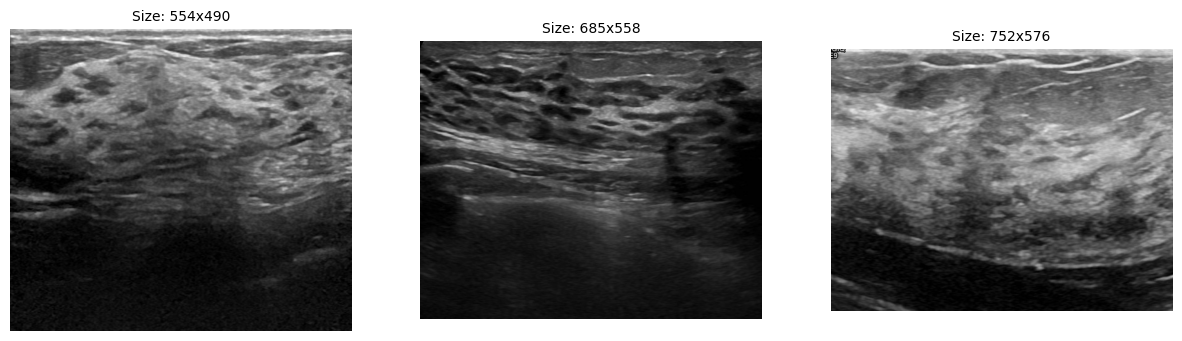


Imágenes de ultrasonido benignas:
/content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (284).png
/content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (119).png
/content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (18).png


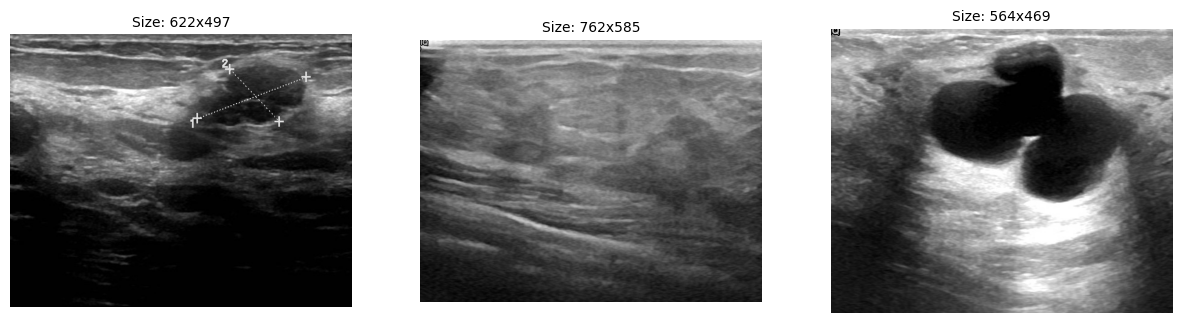


Imágenes de ultrasonido malignas:
/content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (16).png
/content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (6).png
/content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (138).png


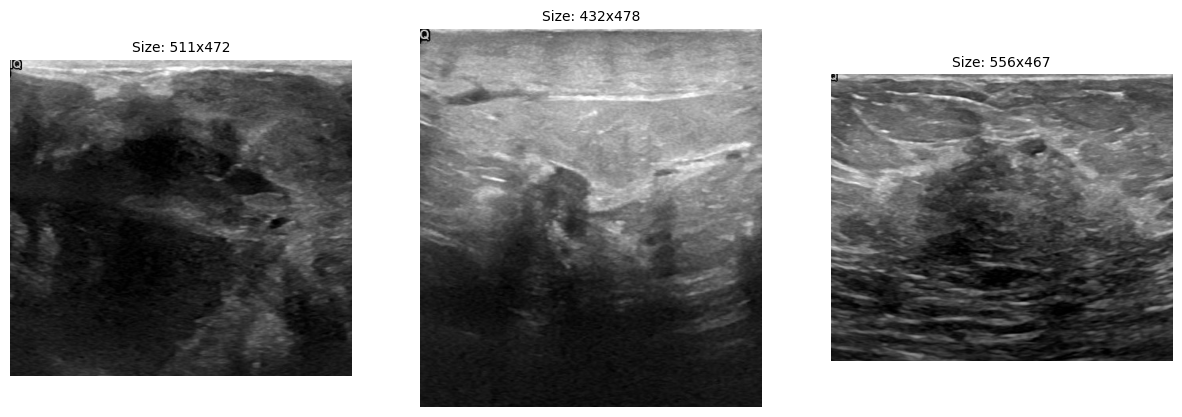

In [ ]:
# Muestra de las primeras tres images de cada etiqueta del dataset
def Mostrar3Imagenes(image_paths):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for i, image_path in enumerate(image_paths):
        if i < len(axes):
            image = cv2.imread(image_path)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            axes[i].imshow(image_rgb)
            axes[i].axis('off')

            # Características de la imagen
            propiedades_imagenes = f"Size: {image.shape[1]}x{image.shape[0]}"
            axes[i].set_title(propiedades_imagenes, fontsize=10)

            # Path de las imagenes
            print(image_path)
    plt.show()

# Seleccion de 3 imagenes de cada categoria sin tomar en cuenta las mascaras
normal_images = random.sample([path for path, (label, _) in dataset.items() if label == 'normal'], 3)
benign_images = random.sample([path for path, (label, _) in dataset.items() if label == 'benign'], 3)
malignant_images = random.sample([path for path, (label, _) in dataset.items() if label == 'malignant'], 3)

print("Imágenes de ultrasonido normales:")
Mostrar3Imagenes(normal_images)
print("\nImágenes de ultrasonido benignas:")
Mostrar3Imagenes(benign_images)
print("\nImágenes de ultrasonido malignas:")
Mostrar3Imagenes(malignant_images)

In [ ]:
# Transformaciones de Augmentations
from albumentations import Compose, HorizontalFlip, VerticalFlip, Rotate, Perspective, Resize, Normalize
from albumentations.pytorch import ToTensorV2

In [ ]:
# Definir transformaciones de datos
transform = Compose([
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
    Rotate(limit=15, p=0.5),
    Resize(224, 224),
    ToTensorV2()
])

In [ ]:
# Función para aplicar transformaciones a una imagen y su máscara
def apply_transforms(image, mask):
    transformed = transform(image=image, mask=mask)
    transformed_image = transformed['image']
    transformed_mask = transformed['mask']
    return transformed_image, transformed_mask

In [ ]:
# Seleccionar el 25% de las imágenes y máscaras para aumentar
augmentation_samples = random.sample(list(train_set.items()), int(len(train_set) * 0.25))

In [ ]:
import os

# Definir los paths de las carpetas de transformación
transformed_paths = {
    'normal': "/content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal_transformed",
    'malignant': "/content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant_transformed",
    'benign': "/content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed"
}

In [ ]:
# Verificar si las carpetas de transformación existen, si no, crearlas
for path in transformed_paths.values():
    if not os.path.exists(path):
        os.makedirs(path)

In [ ]:
transformed_samples = {}
# Aplicar aumento de datos y actualizar el conjunto de entrenamiento
for image_path, (label, mask_path) in augmentation_samples:
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    transformed_image, transformed_mask = apply_transforms(image, mask)

    # Convertir tensores PyTorch a matrices NumPy
    transformed_image = (transformed_image.permute(1, 2, 0).numpy()).astype(np.uint8)
    transformed_mask = transformed_mask.squeeze().numpy().astype(np.uint8)

    # Guardar las imágenes y las máscaras transformadas en las carpetas correspondientes
    transformed_image_path = os.path.join(transformed_paths[label], f"transformed_{os.path.basename(image_path)}")
    transformed_mask_path = os.path.join(transformed_paths[label], f"transformed_{os.path.basename(mask_path)}")

    cv2.imwrite(transformed_image_path, transformed_image)
    cv2.imwrite(transformed_mask_path, transformed_mask)

    # Agregar las transformaciones al conjunto de entrenamiento
    train_set[transformed_image_path] = (label, transformed_mask_path)

    # Agregar la imagen y la máscara transformadas al diccionario
    transformed_samples[transformed_image_path] = (label, transformed_mask_path)

# Actualizar el tamaño del conjunto de entrenamiento
train_set_size = len(train_set)
print("Tamaño del conjunto de entrenamiento después del aumento de datos:", train_set_size)

Tamaño del conjunto de entrenamiento después del aumento de datos: 728


Transformed image: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (123).png
Original image: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (123).png
Transformed mask: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (123)_mask.png
Original mask: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (123)_mask.png
Transformed image: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (156).png
Original image: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (156).png
Transformed mask: /content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign_transformed/transformed_benign (156)_mask.png
Original mask: /con

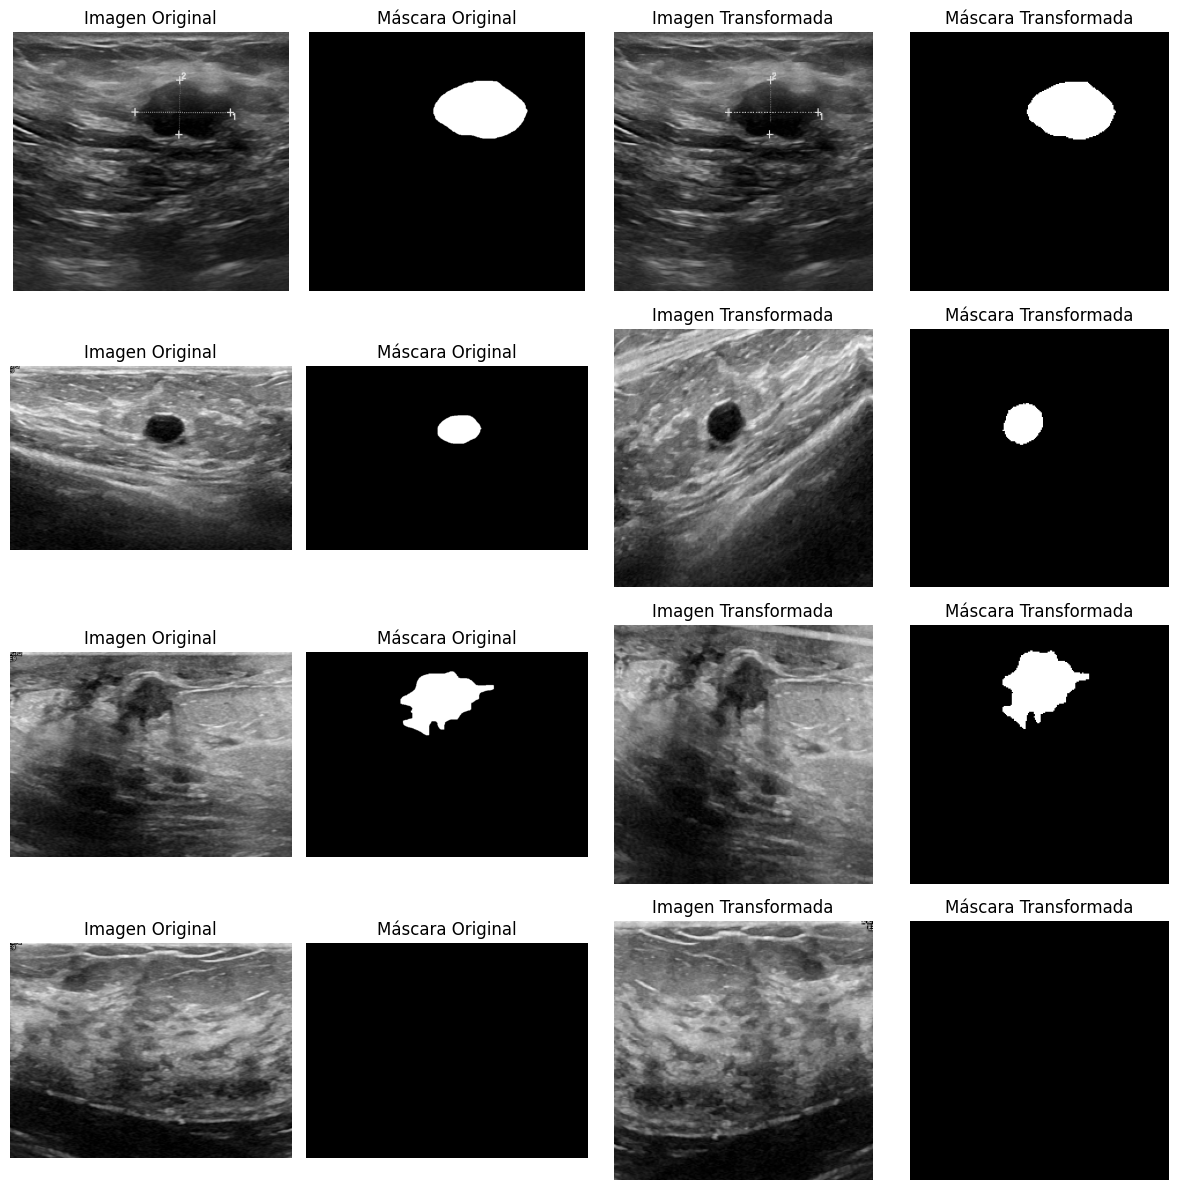

In [ ]:
# Función para mostrar imágenes y máscaras transformadas y originales
def show_transformed_and_original_images(transformed_samples):
    # Seleccionar aleatoriamente 4 imágenes transformadas
    selected_images = random.sample(list(transformed_samples.items()), 4)

    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    for i, (transformed_image_path, (label, transformed_mask_path)) in enumerate(selected_images):
        # Cargar imágenes y máscaras transformadas
        transformed_image = cv2.imread(transformed_image_path)
        transformed_mask = cv2.imread(transformed_mask_path, cv2.IMREAD_GRAYSCALE)

        # Generar los paths correspondientes a las imágenes y máscaras originales
        original_image_filename = os.path.basename(transformed_image_path).replace("transformed_", "")
        original_mask_filename = os.path.basename(transformed_mask_path).replace("transformed_", "")

        # Construir los paths completos para las imágenes y máscaras originales
        original_image_path = os.path.join(os.path.dirname(os.path.dirname(transformed_image_path)), label, original_image_filename)
        original_mask_path = os.path.join(os.path.dirname(os.path.dirname(transformed_mask_path)), label, original_mask_filename)

        print(f"Transformed image: {transformed_image_path}")
        print(f"Original image: {original_image_path}")
        print(f"Transformed mask: {transformed_mask_path}")
        print(f"Original mask: {original_mask_path}")

        # Cargar imágenes originales y sus máscaras originales
        if os.path.exists(original_image_path) and os.path.exists(original_mask_path):
            original_image = cv2.imread(original_image_path)
            original_mask = cv2.imread(original_mask_path, cv2.IMREAD_GRAYSCALE)
        else:
            original_image = None
            original_mask = None

        # Mostrar imágenes y máscaras en el gráfico
        if original_image is not None and original_mask is not None:
            axes[i, 0].imshow(original_image, cmap='gray')
            axes[i, 0].set_title('Imagen Original')
            axes[i, 0].axis('off')
            axes[i, 1].imshow(original_mask, cmap='gray')
            axes[i, 1].set_title('Máscara Original')
            axes[i, 1].axis('off')
        else:
            axes[i, 0].text(0.5, 0.5, 'Imagen Original no encontrada', horizontalalignment='center', verticalalignment='center', transform=axes[i, 0].transAxes)
            axes[i, 1].text(0.5, 0.5, 'Máscara Original no encontrada', horizontalalignment='center', verticalalignment='center', transform=axes[i, 1].transAxes)
            axes[i, 0].axis('off')
            axes[i, 1].axis('off')

        axes[i, 2].imshow(transformed_image, cmap='gray')
        axes[i, 2].set_title('Imagen Transformada')
        axes[i, 2].axis('off')
        axes[i, 3].imshow(transformed_mask, cmap='gray')
        axes[i, 3].set_title('Máscara Transformada')
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

# Mostrar las imágenes y máscaras transformadas y originales
show_transformed_and_original_images(transformed_samples)

In [ ]:
import torch.nn as nn
import torch
import torch.optim as optim
import time

In [ ]:
class UNet(nn.Module):
    def __init__(self, num_channels=1, num_classes=1):
        super(UNet, self).__init__()
        num_feat = [32, 64, 128, 256, 512]

        self.down1 = nn.Sequential(Conv3x3(num_channels, num_feat[0]))
        self.down2 = nn.Sequential(nn.MaxPool2d(kernel_size=2),
                                   Conv3x3(num_feat[0], num_feat[1]))
        self.down3 = nn.Sequential(nn.MaxPool2d(kernel_size=2),
                                   Conv3x3(num_feat[1], num_feat[2]))
        self.down4 = nn.Sequential(nn.MaxPool2d(kernel_size=2),
                                   Conv3x3(num_feat[2], num_feat[3]))
        self.bottom = nn.Sequential(nn.MaxPool2d(kernel_size=2),
                                    Conv3x3(num_feat[3], num_feat[4]))
        self.up1 = UpConcat(num_feat[4], num_feat[3])
        self.upconv1 = Conv3x3(num_feat[4], num_feat[3])
        self.up2 = UpConcat(num_feat[3], num_feat[2])
        self.upconv2 = Conv3x3(num_feat[3], num_feat[2])
        self.up3 = UpConcat(num_feat[2], num_feat[1])
        self.upconv3 = Conv3x3(num_feat[2], num_feat[1])
        self.up4 = UpConcat(num_feat[1], num_feat[0])
        self.upconv4 = Conv3x3(num_feat[1], num_feat[0])
        self.final = nn.Sequential(nn.Conv2d(num_feat[0], num_classes, kernel_size=1), nn.Sigmoid())

    def forward(self, inputs):
        down1_feat = self.down1(inputs)
        down2_feat = self.down2(down1_feat)
        down3_feat = self.down3(down2_feat)
        down4_feat = self.down4(down3_feat)
        bottom_feat = self.bottom(down4_feat)
        up1_feat = self.up1(bottom_feat, down4_feat)
        up1_feat = self.upconv1(up1_feat)
        up2_feat = self.up2(up1_feat, down3_feat)
        up2_feat = self.upconv2(up2_feat)
        up3_feat = self.up3(up2_feat, down2_feat)
        up3_feat = self.upconv3(up3_feat)
        up4_feat = self.up4(up3_feat, down1_feat)
        up4_feat = self.upconv4(up4_feat)
        outputs = self.final(up4_feat)
        return outputs

class Conv3x3(nn.Module):
    def __init__(self, in_feat, out_feat):
        super(Conv3x3, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_feat, out_feat, kernel_size=3, stride=1, padding=1),
                                   nn.BatchNorm2d(out_feat), nn.ReLU(),
                                   nn.Dropout(p=0.3))
        self.conv2 = nn.Sequential(nn.Conv2d(out_feat, out_feat, kernel_size=3, stride=1, padding=1),
                                   nn.BatchNorm2d(out_feat), nn.ReLU(),
                                   nn.Dropout(p=0.3))
    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.conv2(outputs)
        return outputs

class UpConcat(nn.Module):
    def __init__(self, in_feat, out_feat):
        super(UpConcat, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_feat, out_feat, kernel_size=2, stride=2)
    def forward(self, inputs, down_outputs):
        outputs = self.deconv(inputs)
        out = torch.cat([down_outputs, outputs], 1)
        return out

In [ ]:
# Definir el dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Definir el modelo y moverlo al dispositivo adecuado
model = UNet(num_channels=1, num_classes=1).to(device)

In [ ]:
# Definir la función de pérdida y el optimizador
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

In [ ]:
# Función para calcular las métricas
def calculate_metrics(y_true, y_pred):
    y_true = y_true.cpu().detach().numpy().flatten()
    y_pred = (y_pred.cpu().detach().numpy().flatten() > 0.5).astype(int)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    if precision == 0 and recall == 0:
      dice = 0
    else:
      dice = 2 * (precision * recall) / (precision + recall)

    return accuracy, precision, recall, f1, dice

In [ ]:
# Función de entrenamiento
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        start_time = time.time()

        for i, (inputs, masks) in enumerate(train_loader):
            inputs, masks = inputs.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if i % 10 == 9:
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 10:.4f}")
                running_loss = 0.0

        elapsed_time = time.time() - start_time
        print(f"Epoch {epoch + 1} completed in {elapsed_time:.2f}s")
    print("Finished Training")

In [ ]:
# Función de evaluación
def evaluate_model(model, data_loader, criterion):
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    val_precision = 0.0
    val_recall = 0.0
    val_f1 = 0.0
    val_dice = 0.0
    with torch.no_grad():
        for inputs, masks in data_loader:
            inputs, masks = inputs.to(device), masks.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            accuracy, precision, recall, f1, dice = calculate_metrics(masks, outputs)
            val_accuracy += accuracy
            val_precision += precision
            val_recall += recall
            val_f1 += f1
            val_dice += dice

    val_loss /= len(data_loader)
    val_accuracy /= len(data_loader)
    val_precision /= len(data_loader)
    val_recall /= len(data_loader)
    val_f1 /= len(data_loader)
    val_dice /= len(data_loader)

    return val_loss, val_accuracy, val_precision, val_recall, val_f1, val_dice

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data_paths, transform=None):
        self.data_paths = data_paths
        self.transform = transform
        self.samples = []
        # Iterar sobre los directorios de datos y construir las muestras
        for image_path, (label, mask_path) in self.data_paths.items():
            self.samples.append((image_path, mask_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, mask_path, label = self.samples[idx]

        # Cargar la imagen y la máscara
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Aplicar transformaciones si están definidas
        if self.transform:
            image = self.transform(image)

        return image, mask, label

transform = transforms.Compose([
    Resize(224, 224),  # Redimensionar todas las imágenes a 224x224 píxeles
    ToTensorV2(),
])

# Crea el conjunto de datos con la transformación
train_dataset = CustomDataset(train_set, transform=transform)
test_dataset = CustomDataset(test_set, transform=transform)

# Crea los DataLoader con los conjuntos de datos
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Entrenamiento del modelo
num_epochs = 5
train_losses = []
train_accuracies = []
train_precisions = []
train_recalls = []
train_f1s = []
train_dices = []

test_losses = []
test_accuracies = []
test_precisions = []
test_recalls = []
test_f1s = []
test_dices = []

In [ ]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print('-' * 10)

    # Entrenamiento
    model.train()
    running_train_loss = 0.0
    train_corrects = 0
    train_total = 0
    for inputs, masks, labels in train_loader:  # Ahora el dataloader devuelve también las etiquetas
        inputs, masks = inputs.to(device), masks.to(device)

        for image, mask, label in zip(inputs, masks, labels):
            # Verificar si la imagen es original o transformada
            if "transformed_" in label:
                transformed_image_path = os.path.join(transformed_paths[label], image)
                transformed_mask_path = os.path.join(transformed_paths[label], mask)

                transformed_image = cv2.imread(transformed_image_path)
                transformed_mask = cv2.imread(transformed_mask_path, cv2.IMREAD_GRAYSCALE)

                # Normalizar las máscaras
                transformed_mask = transformed_mask / transformed_mask.max()

                outputs = model(transformed_image)
            else:
                original_image_path = os.path.join(train_set[label], image)
                original_mask_path = os.path.join(train_set[label], mask)

                original_image = cv2.imread(original_image_path)
                original_mask = cv2.imread(original_mask_path, cv2.IMREAD_GRAYSCALE)

                # Normalizar las máscaras
                original_mask = original_mask / original_mask.max()

                outputs = model(original_image)

            if outputs.shape[1] == 1:
                outputs = outputs.squeeze(1)

            loss = criterion(outputs, mask)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * inputs.size(0)

            # Calcular métricas de entrenamiento
            accuracy, precision, recall, f1, dice = calculate_metrics(mask, outputs)
            train_corrects += accuracy * inputs.size(0)
            train_total += inputs.size(0)

    epoch_train_loss = running_train_loss / train_total
    epoch_train_accuracy = train_corrects / train_total

    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    print(f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_accuracy:.4f}")

    # Validación
    model.eval()
    running_test_loss = 0.0
    test_corrects = 0
    test_total = 0
    for inputs, masks, labels in test_loader:
        inputs, masks = inputs.to(device), masks.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, masks)
            running_test_loss += loss.item() * inputs.size(0)

            # Calcular métricas de validación
            accuracy, precision, recall, f1, dice = calculate_metrics(masks, outputs)
            test_corrects += accuracy * inputs.size(0)
            test_total += inputs.size(0)

    epoch_test_loss = running_test_loss / test_total
    epoch_test_accuracy = test_corrects / test_total

    test_losses.append(epoch_test_loss)
    test_accuracies.append(epoch_test_accuracy)

    print(f"Val Loss: {epoch_test_loss:.4f} | Val Acc: {epoch_test_accuracy:.4f}")
    print()


Epoch 1/5
----------


KeyError: 'You have to pass data to augmentations as named arguments, for example: aug(image=image)'

In [ ]:
# Graficar los resultados de las métricas
plt.figure(figsize=(12, 6))

plt.subplot(2, 3, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(test_losses, label='Val Loss', color='red')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.plot(test_accuracies, label='Val Accuracy', color='red')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(train_precisions, label='Train Precision', color='blue')
plt.plot(test_precisions, label='Val Precision', color='red')
plt.title('Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(train_recalls, label='Train Recall', color='blue')
plt.plot(test_recalls, label='Val Recall', color='red')
plt.title('Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(train_f1s, label='Train F1', color='blue')
plt.plot(test_f1s, label='Val F1', color='red')
plt.title('F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.subplot(2, 3, 6)
plt.plot(train_dices, label='Train Dice', color='blue')
plt.plot(test_dices, label='Val Dice', color='red')
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()

plt.tight_layout()
plt.show()